In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

윈도우용 mecab설치 설명사이트   https://hong-yp-ml-records.tistory.com/91

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#-*- coding: utf-8 -*
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim import corpora, models

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.pylab import rcParams
# rcParams['font.family'] ='malgun Gothic' #window 맑은고딕
rcParams['font.family'] ='AppleGothic' #맥os 애플고딕
rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print('LDAVis Version :', pyLDAvis.__version__)
print('Pandas Version :', pd.__version__)

# 데이터 읽기

In [5]:
data1 = pd.read_csv('/content/drive/MyDrive/DCX/0. SNA 재할당/cluster5_seg1_식사를챙길여유가없는액터.csv', encoding = 'utf-8-sig', index_col = 0)
data1

,review,review_token,eigen_dict0,eigen_dict1,final
0,오늘의 도시락 컬리플라워라이스 볶음밥 밥을인척하는 야채들 젛다좋다 이거 진짜 밥같오...,"['맛', '이쁘다', '도시락', '우왓', '따다', '짐', '걸다', '식'...",0.000000,11.880232,1
1,인바디 재볼 수 있는 곳 있나 걍 헬스장 가면 재주나 보건소 보건소는 퇴근하는 시간...,"['짜다', '공단', '찌다', '천만원', '한의원', '시간', '곳', '재...",2.123234,11.422749,1
2,회식 점심에 좀 하면 좋겠다 퇴근하고 시간은 좀 냅두면 안되냐 아이고 아이고 아아 ...,"['자기', '종종', '아아', '점심', '술', '항상', '가라', '우린'...",2.726206,22.789024,1
5,숙취해소제 신랑은 아무리 섞어마시고 많이 마셔도 숙취가 1도 없데요..근데 저는 담...,"['앜', '맛', '포', '찾다', '다해', '역시', '계속', '깨다', ...",15.812635,16.059521,1
6,곰곰 닭가슴살 어때 싸고 단백질 많던데 추천하는 사람이 없네 곰곰비싸 다시 보니깐 ...,"['가슴', '오', '단백질', '보', '다시', '추천', '싸다', '적',...",0.737012,2.116928,1
...,...,...,...,...,...
30368,홍삼 좋아하는 사람들 개꿀팁 영양제승 추석에 반년치 사놨었는데 이제 슬슬 또 반년치...,"['영양', '또', '놓다', '좋아하다', '치', '홍삼', '사람', '쟁'...",0.000000,2.156541,1
30369,홍삼 매년 홍삼선물을 받는데 다들 홍삼을 안 드셔서 썩어서 버리게되더라구요 머그면 ...,"['썩다', '받다', '물', '여우', '좋아하다', '효능', '머그', '가...",2.126669,2.792297,1
30371,정관장 아닌데 친척 어르신들이 홍삼 싸게 구매할 수 있냐고 물어보시넹 나도 엘지전자...,"['나다', '가전', '나', '고프다', '죳소', '알', '싸다', '물어보...",0.000000,1.430315,1
30378,밀크씨슬 다들 어디꺼 먹어 추천좀 해줘 세노비스 나우푸드 gnc 대면 밀크씨슬 아직...,"['어디', '푸드', '노비', '스', '들다', '싸다', '슬', '대면',...",0.000000,0.691478,1


In [6]:
from tqdm import tqdm
import ast

tqdm.pandas()
data1['review_token'] = data1['review_token'].progress_apply(eval) # string to list
data1

100%|██████████| 13231/13231 [00:01<00:00, 11956.01it/s]


,review,review_token,eigen_dict0,eigen_dict1,final
0,오늘의 도시락 컬리플라워라이스 볶음밥 밥을인척하는 야채들 젛다좋다 이거 진짜 밥같오...,"[맛, 이쁘다, 도시락, 우왓, 따다, 짐, 걸다, 식, 밥, 라이스, 플라워, 자...",0.000000,11.880232,1
1,인바디 재볼 수 있는 곳 있나 걍 헬스장 가면 재주나 보건소 보건소는 퇴근하는 시간...,"[짜다, 공단, 찌다, 천만원, 한의원, 시간, 곳, 재볼, 인바디, 건강, 퇴근,...",2.123234,11.422749,1
2,회식 점심에 좀 하면 좋겠다 퇴근하고 시간은 좀 냅두면 안되냐 아이고 아이고 아아 ...,"[자기, 종종, 아아, 점심, 술, 항상, 가라, 우린, 두다, 시간, 회식, 회사...",2.726206,22.789024,1
5,숙취해소제 신랑은 아무리 섞어마시고 많이 마셔도 숙취가 1도 없데요..근데 저는 담...,"[앜, 맛, 포, 찾다, 다해, 역시, 계속, 깨다, 유리, 약국, 여명, 썩, 신...",15.812635,16.059521,1
6,곰곰 닭가슴살 어때 싸고 단백질 많던데 추천하는 사람이 없네 곰곰비싸 다시 보니깐 ...,"[가슴, 오, 단백질, 보, 다시, 추천, 싸다, 적, 먹다, 없다, 굳다, 숙란,...",0.737012,2.116928,1
...,...,...,...,...,...
30368,홍삼 좋아하는 사람들 개꿀팁 영양제승 추석에 반년치 사놨었는데 이제 슬슬 또 반년치...,"[영양, 또, 놓다, 좋아하다, 치, 홍삼, 사람, 쟁, 개꿀팁, 이제, 추석, 사...",0.000000,2.156541,1
30369,홍삼 매년 홍삼선물을 받는데 다들 홍삼을 안 드셔서 썩어서 버리게되더라구요 머그면 ...,"[썩다, 받다, 물, 여우, 좋아하다, 효능, 머그, 가요, 타, 관장, 짐, 기운...",2.126669,2.792297,1
30371,정관장 아닌데 친척 어르신들이 홍삼 싸게 구매할 수 있냐고 물어보시넹 나도 엘지전자...,"[나다, 가전, 나, 고프다, 죳소, 알, 싸다, 물어보다, 법, 임, 먹다, 파다...",0.000000,1.430315,1
30378,밀크씨슬 다들 어디꺼 먹어 추천좀 해줘 세노비스 나우푸드 gnc 대면 밀크씨슬 아직...,"[어디, 푸드, 노비, 스, 들다, 싸다, 슬, 대면, 해주다, 먹다, 밀크, 나우...",0.000000,0.691478,1


# 토큰화 결과 값을 보고 stopwords 추가
- 그런데...stopwords 추가 안한게 더 잘나오는 경우도 있긴 해요...
- 이건 상황에 맞춰서 돌려주세용

In [7]:
words = data1['review_token'].tolist()

stopwords = ['존나', '너무', '많이', '정도','아니','지금','거의','진짜','그냥','괜찮', '정말', '오늘', '시발', '씨발',
             '요즘', '경우', '이제', '물론', '어제', '대로', '만큼', '뿐', '가요', '안녕', '모르', '궁금', '혹시', '야하다',
            '등', '등등', '드리다', '이', '그', '저', '이거', '그거', '저거', '때', '그때', '이때', '저때']
# ~해야한다가 토큰화하면 야하다로 나오네요...

filtered_words=[]
for w in words:
    a=[]
    for w1 in w:
        if w1 not in stopwords:
            a.append(w1)
    filtered_words.append(a)

data1['review_token'] = filtered_words
data1

,review,review_token,eigen_dict0,eigen_dict1,final
0,오늘의 도시락 컬리플라워라이스 볶음밥 밥을인척하는 야채들 젛다좋다 이거 진짜 밥같오...,"[맛, 이쁘다, 도시락, 우왓, 따다, 짐, 걸다, 식, 밥, 라이스, 플라워, 자...",0.000000,11.880232,1
1,인바디 재볼 수 있는 곳 있나 걍 헬스장 가면 재주나 보건소 보건소는 퇴근하는 시간...,"[짜다, 공단, 찌다, 천만원, 한의원, 시간, 곳, 재볼, 인바디, 건강, 퇴근,...",2.123234,11.422749,1
2,회식 점심에 좀 하면 좋겠다 퇴근하고 시간은 좀 냅두면 안되냐 아이고 아이고 아아 ...,"[자기, 종종, 아아, 점심, 술, 항상, 가라, 우린, 두다, 시간, 회식, 회사...",2.726206,22.789024,1
5,숙취해소제 신랑은 아무리 섞어마시고 많이 마셔도 숙취가 1도 없데요..근데 저는 담...,"[앜, 맛, 포, 찾다, 다해, 역시, 계속, 깨다, 유리, 약국, 여명, 썩, 신...",15.812635,16.059521,1
6,곰곰 닭가슴살 어때 싸고 단백질 많던데 추천하는 사람이 없네 곰곰비싸 다시 보니깐 ...,"[가슴, 오, 단백질, 보, 다시, 추천, 싸다, 적, 먹다, 없다, 굳다, 숙란,...",0.737012,2.116928,1
...,...,...,...,...,...
30368,홍삼 좋아하는 사람들 개꿀팁 영양제승 추석에 반년치 사놨었는데 이제 슬슬 또 반년치...,"[영양, 또, 놓다, 좋아하다, 치, 홍삼, 사람, 쟁, 개꿀팁, 추석, 사다, 슬...",0.000000,2.156541,1
30369,홍삼 매년 홍삼선물을 받는데 다들 홍삼을 안 드셔서 썩어서 버리게되더라구요 머그면 ...,"[썩다, 받다, 물, 여우, 좋아하다, 효능, 머그, 타, 관장, 짐, 기운, 형태...",2.126669,2.792297,1
30371,정관장 아닌데 친척 어르신들이 홍삼 싸게 구매할 수 있냐고 물어보시넹 나도 엘지전자...,"[나다, 가전, 나, 고프다, 죳소, 알, 싸다, 물어보다, 법, 임, 먹다, 파다...",0.000000,1.430315,1
30378,밀크씨슬 다들 어디꺼 먹어 추천좀 해줘 세노비스 나우푸드 gnc 대면 밀크씨슬 아직...,"[어디, 푸드, 노비, 스, 들다, 싸다, 슬, 대면, 해주다, 먹다, 밀크, 나우...",0.000000,0.691478,1


In [8]:
data1['review_token']

0        [맛, 이쁘다, 도시락, 우왓, 따다, 짐, 걸다, 식, 밥, 라이스, 플라워, 자...
1        [짜다, 공단, 찌다, 천만원, 한의원, 시간, 곳, 재볼, 인바디, 건강, 퇴근,...
2        [자기, 종종, 아아, 점심, 술, 항상, 가라, 우린, 두다, 시간, 회식, 회사...
5        [앜, 맛, 포, 찾다, 다해, 역시, 계속, 깨다, 유리, 약국, 여명, 썩, 신...
6        [가슴, 오, 단백질, 보, 다시, 추천, 싸다, 적, 먹다, 없다, 굳다, 숙란,...
                               ...                        
30368    [영양, 또, 놓다, 좋아하다, 치, 홍삼, 사람, 쟁, 개꿀팁, 추석, 사다, 슬...
30369    [썩다, 받다, 물, 여우, 좋아하다, 효능, 머그, 타, 관장, 짐, 기운, 형태...
30371    [나다, 가전, 나, 고프다, 죳소, 알, 싸다, 물어보다, 법, 임, 먹다, 파다...
30378    [어디, 푸드, 노비, 스, 들다, 싸다, 슬, 대면, 해주다, 먹다, 밀크, 나우...
30387    [뎅, 앞, 안보, 싸다, 코어, 수량, 뭐, 누르다, 남다, 노안, 일, 뉴, 초...
Name: review_token, Length: 13231, dtype: object

## LDA

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data1['review_token'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data1['review_token']]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.1933125633491324),
 (1, 0.06030812311993875),
 (2, 0.1707451093151161),
 (3, 0.08327246047389872),
 (4, 0.12952161165554205),
 (5, 0.21574277182438825),
 (6, 0.15613446619277482),
 (7, 0.06487677945350219),
 (8, 0.05513810747871518),
 (9, 0.07284993784524926),
 (10, 0.1508480302722416),
 (11, 0.15318996750196198),
 (12, 0.08754834618102385),
 (13, 0.3131274538339993),
 (14, 0.18685527189679213),
 (15, 0.3131274538339993),
 (16, 0.07772042393031908),
 (17, 0.34953402092789987),
 (18, 0.17825498019628408),
 (19, 0.3770745257667827),
 (20, 0.33342385834622384),
 (21, 0.18587417143847326),
 (22, 0.2997585539513937)]


# perplexity & coherence
- 만약 데이터 수가 많다면 topic수를 더 늘려서 봐야함 (for 구문 arange 조정하기)

In [10]:
# perlplexity혼란도: 낮을수록 좋다.
import gensim
import matplotlib.pyplot as plt
perplexity_values = []
for i in range(1,30): # 여기 조정하기
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = id2word)
    perplexity_values.append(ldamodel.log_perplexity(corpus_tfidf))

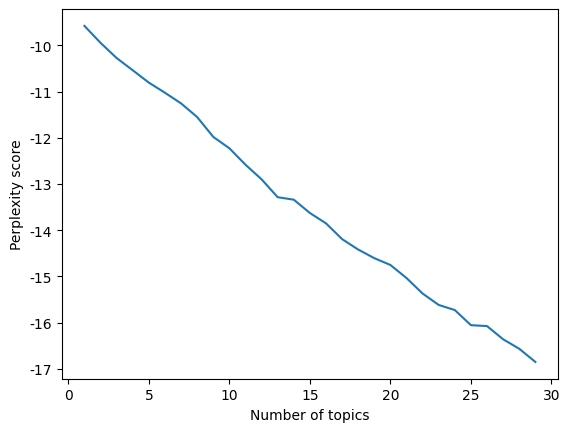

In [11]:
x = range(1,30)
plt.plot(x, perplexity_values)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

In [ ]:
# 유사도: 높을수록 좋음.
# 정말 오래걸림...ㅎㅎ

from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
from gensim.models.coherencemodel import CoherenceModel

preprocessed_docs = [''.join(doc) for doc in data1['review_token']]

coherence_values = []
for i in range(1,30):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = id2word)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=data1.review_token.values.tolist(), dictionary=id2word,topn=10) #상위 10개의 단어들을 이용하여 유사도를 알아본다.
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

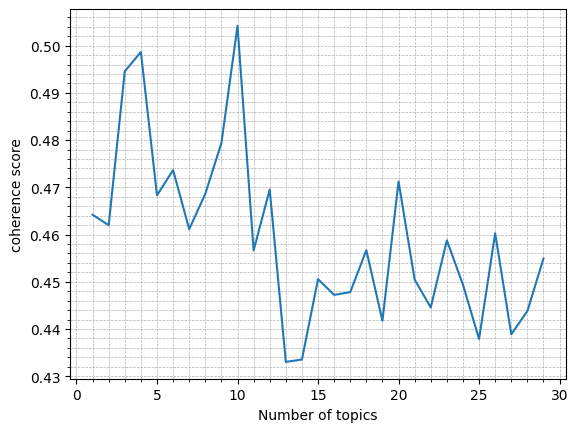

In [ ]:
x = range(1,30)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()  # 부가 눈금선 표시
plt.show()

# LDA 토픽 개수 정하기
- 위 그래프를 바탕으로 적정한 토픽 개수 정하기

In [ ]:
# 위 그래프를 바탕으로 임의의 K 선정
num_topics = 8
os.mkdir(f"/content/drive/MyDrive/DCX/lda_test{num_topics}")
os.mkdir(f"/content/drive/MyDrive/DCX/lda_test{num_topics}/model")
os.mkdir(f"/content/drive/MyDrive/DCX/lda_test{num_topics}/topic")
os.mkdir(f"/content/drive/MyDrive/DCX/lda_test{num_topics}/html")

In [ ]:
#저장된 모델 불러오기
# import gensim
# from gensim.models.ldamodel import LdaModel
# ldamodel = gensim.models.ldamodel.LdaModel.load("lda.model")

In [ ]:
%matplotlib inline
import pandas as pd
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import gensim

In [ ]:
seg = 'seg1_식사챙길여유없는액터'

In [ ]:
for i in range(10):
    random_state = i
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics,per_word_topics=True, eval_every = 1,
                                            id2word = id2word, passes=4, alpha=[0.01]*num_topics, eta=[0.01]*len(id2word.keys()), random_state=random_state)
    for idx, topic in ldamodel.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))

    #모델저장
    ldamodel.save(f'/content/drive/MyDrive/DCX/lda_test{num_topics}/model/lda.model{i}')
    topic_dfs = []

    for i in range(num_topics):
        words = ldamodel.show_topic(i, topn=30)
        topic_words = [(word, prob) for word, prob in words]  # Separate word and probability

        df = pd.DataFrame(topic_words, columns=[f'topic{i}_word', f'topic{i}_prob'])
        topic_dfs.append(df)


    empty=[]
    for n in range(len(topic_dfs)):
        topic_df = topic_dfs[n]
        empty.append(topic_df)

    final_lda=pd.concat(empty, axis=1)
    # 세그먼트 이름 꼭 바꿔주세요
    final_lda.to_csv(f'/content/drive/MyDrive/DCX/lda_test{num_topics}/topic/seg0_테스트_topic{i}.csv')

    pyLDAvis.enable_notebook()

    vis = gensimvis.prepare(topic_model=ldamodel, corpus=corpus, dictionary=id2word)

    #시각화 저장
    # 세그먼트 이름 꼭 바꿔주세요
    pyLDAvis.save_html(vis, f'/content/drive/MyDrive/DCX/lda_test{num_topics}/html/{seg}_테스트_graph_{random_state}.html')
    pyLDAvis.display(vis)

Topic: 0 Word: 0.027*"먹다" + 0.023*"맛있다" + 0.019*"과일" + 0.014*"넣다" + 0.014*"야채" + 0.014*"맛" + 0.009*"샐러드" + 0.009*"좋다" + 0.008*"보다" + 0.008*"만들다"
Topic: 1 Word: 0.017*"먹다" + 0.015*"제로" + 0.012*"보다" + 0.010*"과일" + 0.009*"그렇다" + 0.009*"없다" + 0.008*"맛" + 0.008*"말다" + 0.008*"콜라" + 0.008*"거"
Topic: 2 Word: 0.032*"먹다" + 0.020*"반찬" + 0.014*"맛있다" + 0.013*"밥" + 0.013*"집" + 0.012*"뭐" + 0.011*"야채" + 0.011*"도시락" + 0.010*"시키다" + 0.010*"메뉴"
Topic: 3 Word: 0.017*"먹다" + 0.009*"그렇다" + 0.008*"없다" + 0.007*"나" + 0.007*"보다" + 0.007*"좋다" + 0.006*"들다" + 0.005*"거" + 0.005*"나다" + 0.005*"사람"
Topic: 4 Word: 0.023*"먹다" + 0.019*"좋다" + 0.017*"추천" + 0.015*"뭐" + 0.014*"간식" + 0.010*"건강" + 0.009*"들다" + 0.008*"거" + 0.008*"아몬드" + 0.008*"해주다"
Topic: 5 Word: 0.073*"닭" + 0.071*"가슴" + 0.067*"살" + 0.038*"먹다" + 0.016*"도시락" + 0.016*"냉동" + 0.015*"다이어트" + 0.013*"괜찮다" + 0.012*"추천" + 0.011*"샐러드"
Topic: 6 Word: 0.029*"점심" + 0.028*"먹다" + 0.025*"저녁" + 0.022*"아침" + 0.019*"운동" + 0.011*"시간" + 0.010*"밥" + 0.009*"다이어트" + 0.009*"식단" + 0.008*

# HTML에서 선택한 모델 랜덤시드 설정하고, LDA 모델 저장하기 !

#### 아래 코드는 어차피 random_seed 넣어서 돌릴 때 저장됐는데 혹시 몰라서 킵해둠!

In [ ]:
i = 9 #### random_state = html 뒤에 있는 숫자 넣기 !!
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics,per_word_topics=True, eval_every = 1,
                                        id2word = id2word, passes=4, alpha=[0.01]*num_topics,
                                        eta=[0.01]*len(id2word.keys()), random_state= i )
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

#모델저장
ldamodel.save(f'./lda_test{num_topics}/lda.model{i}')
topic_dfs = []

for i in range(num_topics):
    words = ldamodel.show_topic(i, topn=30)
    topic_words = [(word, prob) for word, prob in words]  # Separate word and probability

    df = pd.DataFrame(topic_words, columns=[f'topic{i}_word', f'topic{i}_prob'])
    topic_dfs.append(df)


empty=[]
for n in range(len(topic_dfs)):
    topic_df = topic_dfs[n]
    empty.append(topic_df)

final_lda=pd.concat(empty, axis=1)
# 세그먼트 이름 꼭 바꿔주세요
final_lda.to_csv(f'./lda_test{num_topics}/seg0_테스트_topic{i}.csv', encoding = 'utf-8-sig')

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(topic_model=ldamodel, corpus=corpus, dictionary=id2word)

#시각화 저장
# 세그먼트 이름 꼭 바꿔주세요
pyLDAvis.save_html(vis, f'./lda_test{num_topics}/{seg}_테스트_graph_{i}.html')
pyLDAvis.display(vis)

## LDA모델-시각화모델 토픽 번호 매핑해서 데이터프레임 빼오기

In [ ]:
# num_topics = 8
random_state = 9 # << html에서 선택한 모델 랜덤시드 설정!!!

# LDA 모델 생성 (실제 데이터로 대체 필요)
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus, num_topics=num_topics, per_word_topics=True, eval_every=1,
    id2word=id2word, passes=4, alpha=[0.01]*num_topics,
    eta=[0.01]*len(id2word.keys()), random_state=random_state
)

# pyLDAvis 시각화 준비
vis_data = gensimvis.prepare(ldamodel, corpus, id2word)

# pyLDAvis에서 각 토픽의 주요 키워드 추출
pyldavis_topic_keywords = {}
for topic_idx in range(num_topics):
    topic_terms = vis_data.topic_info[vis_data.topic_info['Category'] == f'Topic{topic_idx + 1}']
    pyldavis_topic_keywords[topic_idx] = set(topic_terms['Term'].tolist()[:10])  # 상위 10개 단어만 사용

# LDA 모델에서 각 토픽의 주요 키워드 추출
ldamodel_topic_keywords = {topic_num: set([word for word, _ in ldamodel.show_topic(topic_num, topn=10)]) for topic_num in range(num_topics)}

# 토픽 번호 매핑 함수
def map_topic_numbers(ldamodel_topic_keywords, pyldavis_topic_keywords):
    mapping = {}
    for lda_topic_num, lda_keywords in ldamodel_topic_keywords.items():
        best_match = None
        best_similarity = 0.0
        for py_topic_num, py_keywords in pyldavis_topic_keywords.items():
            similarity = len(lda_keywords.intersection(py_keywords)) / len(lda_keywords.union(py_keywords))
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = py_topic_num + 1  # pyLDAvis의 토픽 번호는 1부터 시작
        if best_match is not None:
            mapping[lda_topic_num] = best_match
    return mapping

# 토픽 번호 매핑 생성 및 확인
topic_mapping = map_topic_numbers(ldamodel_topic_keywords, pyldavis_topic_keywords)
print("Topic Mapping:", topic_mapping)

# 각 문서에서 주요 토픽 추출
data_rows = []
for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)

    # 각 문서의 Dominant 토픽, Perc Contribution, 키워드 추출
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # Dominant 토픽
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            mapped_topic = topic_mapping.get(topic_num, topic_num)  # 토픽 매핑 적용
            data_row = [int(mapped_topic), round(prop_topic, 4), topic_keywords, data1.iloc[i]['review']]
            data_rows.append(data_row)

# 수집된 데이터로 데이터프레임 생성
columns = ['topic', 'topic_weight', 'Topic_Keywords', 'Content']
sent_topics_df = pd.DataFrame(data_rows, columns=columns)

# CSV 저장 전에 데이터프레임 출력 확인
print(sent_topics_df)

# 대표 문장 뽑기
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = sent_topics_df.groupby('topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['topic_weight'], ascending=False).head(1)],
                                            axis=0)

sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.iloc[:, 0:4]

# CSV 저장
sent_topics_sorteddf_mallet.to_csv(f'./lda_test{num_topics}/{seg}_토픽_대표문장_seed{random_state}.csv', encoding='utf-8-sig', index=False)

print(sent_topics_sorteddf_mallet)

Topic Mapping: {1: 8}
       topic  topic_weight                              Topic_Keywords   
0          7        0.9968  추천, 해주다, 먹다, 도시락, 보다, 괜찮다, 좋다, 마싯다, 시키다, 거  \
1          8        0.7645        운동, 먹다, 시간, 좋다, 유, 분, 산소, 없다, 저녁, 자다   
2          5        0.5702      먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다   
3          5        0.5972      먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다   
4          6        0.9967        먹다, 제로, 맛, 거, 맛있다, 좋다, 프로, 보다, 없다, 살   
...      ...           ...                                         ...   
13226      5        0.9937      먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다   
13227      3        0.4757       먹다, 그렇다, 보다, 없다, 거, 들다, 자다, 나다, 물, 말다   
13228      6        0.7488        먹다, 제로, 맛, 거, 맛있다, 좋다, 프로, 보다, 없다, 살   
13229      7        0.5991  추천, 해주다, 먹다, 도시락, 보다, 괜찮다, 좋다, 마싯다, 시키다, 거   
13230      8        0.4986        운동, 먹다, 시간, 좋다, 유, 분, 산소, 없다, 저녁, 자다   

                                                 Content  
0      오늘의 도시락 컬리플라워라이스 볶음밥 밥을

# Relevance 적용한 topic 단어 추출 (참고용)
- 위에서 돌린 키워드의 특징이 뚜렷하지 않을때 Relevance score를 적용합니다
- 보통 0.6을 적정한 수치로 적용
- (김은회, & 서유화. (2020). 토픽 레이블링을 위한 토픽 키워드 산출 방법. (사) 디지털산업정보학회 논문지, 16(3), 25-36.)

In [ ]:
#relevace score 적용한 topic 모델링 단어
all_topics = {}
lambd = 0.6  # Adjust this accordingly
for i in range(1,9): #최종 토픽 수로 조정해야합니다!
    topic = vis.topic_info[vis.topic_info\
            .Category == 'Topic'+str(i)]
    topic['relevance'] = topic['loglift']*(1-lambd)\
                         +topic['logprob']*lambd
    #display(topic)
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:10].values #상위 10개 단어 보여주기

relevance_topic=pd.DataFrame(all_topics)
relevance_topic.to_csv(f'./lda_test{num_topics}/{seg}_relevance1_seed9.csv', encoding = 'utf-8-sig')
relevance_topic

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,먹다,비싸다,점심,그렇다,제로,추천,과일,운동
1,맛있다,만원,살,물,프로,해주다,딸기,유
2,넣다,돈,닭,냄새,콜라,마싯다,사과,산소
3,야채,집,가슴,냉장고,틴,도시락,맛있다,헬스
4,맛,좋다,저녁,버리다,맛,헬린,망고,시간
5,반찬,가격,먹다,보다,음료,괜찮다,수박,웨이
6,만들다,비,아침,말다,먹다,시키다,복숭아,분
7,뭐,원,다이어트,기한,단백질,보다,바나나,퇴근
8,밥,주다,식단,약,높다,곳,토마토,헬스장
9,좋아하다,사먹다,운동,유통,거,주문,블루베리,미만


In [ ]:
pyLDAvis.display(vis)

In [ ]:
sent_topics_df

,topic,topic_weight,Topic_Keywords,Content
0,7,0.9968,"추천, 해주다, 먹다, 도시락, 보다, 괜찮다, 좋다, 마싯다, 시키다, 거",오늘의 도시락 컬리플라워라이스 볶음밥 밥을인척하는 야채들 젛다좋다 이거 진짜 밥같오...
1,8,0.7645,"운동, 먹다, 시간, 좋다, 유, 분, 산소, 없다, 저녁, 자다",인바디 재볼 수 있는 곳 있나 걍 헬스장 가면 재주나 보건소 보건소는 퇴근하는 시간...
2,5,0.5702,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",회식 점심에 좀 하면 좋겠다 퇴근하고 시간은 좀 냅두면 안되냐 아이고 아이고 아아 ...
3,5,0.5972,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",숙취해소제 신랑은 아무리 섞어마시고 많이 마셔도 숙취가 1도 없데요..근데 저는 담...
4,6,0.9967,"먹다, 제로, 맛, 거, 맛있다, 좋다, 프로, 보다, 없다, 살",곰곰 닭가슴살 어때 싸고 단백질 많던데 추천하는 사람이 없네 곰곰비싸 다시 보니깐 ...
...,...,...,...,...
13226,5,0.9937,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",홍삼 좋아하는 사람들 개꿀팁 영양제승 추석에 반년치 사놨었는데 이제 슬슬 또 반년치...
13227,3,0.4757,"먹다, 그렇다, 보다, 없다, 거, 들다, 자다, 나다, 물, 말다",홍삼 매년 홍삼선물을 받는데 다들 홍삼을 안 드셔서 썩어서 버리게되더라구요 머그면 ...
13228,6,0.7488,"먹다, 제로, 맛, 거, 맛있다, 좋다, 프로, 보다, 없다, 살",정관장 아닌데 친척 어르신들이 홍삼 싸게 구매할 수 있냐고 물어보시넹 나도 엘지전자...
13229,7,0.5991,"추천, 해주다, 먹다, 도시락, 보다, 괜찮다, 좋다, 마싯다, 시키다, 거",밀크씨슬 다들 어디꺼 먹어 추천좀 해줘 세노비스 나우푸드 gnc 대면 밀크씨슬 아직...


In [ ]:
sent_topics_sorteddf_mallet

,topic,topic_weight,Topic_Keywords,Content
7946,0,0.9986,"먹다, 맛있다, 맛, 넣다, 야채, 뭐, 좋다, 밥, 들다, 반찬",어린아이들과 외식이나 배달할때 주로 메뉴가 어떻게 되세요? 6세여아 매운거 전혀못먹...
915,2,0.9979,"과일, 먹다, 맛있다, 맛, 사과, 좋다, 딸기, 뭐, 추천, 바나나",요즘 과일 머드세요? 딸기 감귤류 사과류거의 먹는데 딴거좀 없나요? 천혜향. 참외 ...
6100,3,0.9977,"먹다, 그렇다, 보다, 없다, 거, 들다, 자다, 나다, 물, 말다",숙취해소 여.명 마시면 술깬다더니 토가 나오는데 정상인가요? 먹고 울렁...ㅠ 속병...
426,4,0.9981,"먹다, 점심, 살, 저녁, 닭, 가슴, 아침, 밥, 다이어트, 운동",몸무게 젤때요~ 아침에 일어났을때 재는 몸무게가 맞는건가요?? 요즘 1일1식하는중인...
7908,5,0.9989,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",토일 외식+배달 총 얼마쓰세요? 감사합니당 그럼 님이 얼마를 쓰는지 알려주세요. 배...
33,6,0.9979,"먹다, 제로, 맛, 거, 맛있다, 좋다, 프로, 보다, 없다, 살",캬 코카라이트 괜찮네 코카제로만 먹다가 코카라이트로 바꿨는데 같은 제로여도 맛이 코...
615,7,0.9982,"추천, 해주다, 먹다, 도시락, 보다, 괜찮다, 좋다, 마싯다, 시키다, 거",직장인 점심 도시락 괜찮은거 추천해주세요!! 회사 원래있던 부서에서는 구내식당이 있...
831,8,0.9987,"운동, 먹다, 시간, 좋다, 유, 분, 산소, 없다, 저녁, 자다",직장인분들 남은 점심시간 뭐하세요? 저는 도시락 먹어서 시간이 많이 남아요^^ 양치...


In [ ]:
sent_topics_df['tokenizing']=data1['review_token'].values
sent_topics_df.sort_values(by=['topic_weight', 'topic'], axis=0, ascending=False, inplace = True)

#csv 저장
sent_topics_df.to_csv(f'./lda_test{num_topics}/LDA결과_{seg}seed{random_state}_fn.csv', encoding = 'utf-8-sig')
sent_topics_df

,topic,topic_weight,Topic_Keywords,Content,tokenizing
7908,5,0.9989,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",토일 외식+배달 총 얼마쓰세요? 감사합니당 그럼 님이 얼마를 쓰는지 알려주세요. 배...,"[나다, 냄새, 삼겹살, 쓰다, 해먹, 애, 인기, 장, 주말, 곳도, 지다, 끼,..."
1041,5,0.9988,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",요새 외식 많이 하시나요 저는 코로나때 배달이 질리기도 했고 물가가 너무 비싸서 요...,"[생일, 요새, 기도, 주말, 일주일, 도시락, 곳, 찾아다니다, 전혀, 저희, 위..."
831,8,0.9987,"운동, 먹다, 시간, 좋다, 유, 분, 산소, 없다, 저녁, 자다",직장인분들 남은 점심시간 뭐하세요? 저는 도시락 먹어서 시간이 많이 남아요^^ 양치...,"[내려놓다, 걷다, 차, 도시락, 남아, 잡다, 점심, 사르다, 남아도, 직장, 직..."
1030,5,0.9987,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",요즘 밀키트 잘해먹으면 퀄리티 좋네요 예전에 밀키트에 대한 불신이 좀 있었는데 최근...,"[국물, 보고, 해먹, 종종, 해장국, 부담, 대한, 곳, 불신, 위주, 사서, 쿠..."
7622,0,0.9986,"먹다, 맛있다, 맛, 넣다, 야채, 뭐, 좋다, 밥, 들다, 반찬",남편이 밥을 잘 차려주는데 별건 아니지만 어제는 김치찌개랑 호박전 해놨떠라구요 퇴근...,"[나다, 차리다, 뜨다, 주말, 못, 어렵다, 계란말이, 충분하다, 건, 장조림, ..."
...,...,...,...,...,...
711,6,0.2056,"먹다, 제로, 맛, 거, 맛있다, 좋다, 프로, 보다, 없다, 살","먹고나서 금방 기력 생기게 하고, 간단히 먹을 수 있는 음식 뭐가 있을까요? 아침에...","[단백질, 포테이토, 샐러드, 덥다, 스뀌즈, 전, 시간, 활, 회복, 식빵, 에너..."
7811,3,0.2004,"먹다, 그렇다, 보다, 없다, 거, 들다, 자다, 나다, 물, 말다",야채 탈수기 요즘 다이어트 하느라 한끼는 야채샐러드랑 닭가슴살로 먹고 있는데 야채 ...,"[가슴, 쏘스, 받다, 살로, 물, 이름, 속옷, 이케아, 합리, 샐러드, 남아, ..."
13077,5,0.1977,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",서브웨이 매일 먹으니 똥 잘나와 변비걸린 애들아 강추 내 지갑에서도 돈 잘나가는 소...,"[나다, 포만, 치베, 두다, 평가, 야간, 팬, 내, 먹어주다, 웨지, 달다, 매..."
3586,5,0.1951,"먹다, 좋다, 없다, 집, 비싸다, 보다, 그렇다, 들다, 거, 많다",인간사료라고 해서 사봤는데 오트밀 바이트가 인간사료로 유명하더라구 먹어보고 싶었는데...,"[나다, 간도, 이름, 부드러움, 인기, 레인, 끝맛, 프라이어, 아무, 역시, 사..."
